# Environment Setup

In [ ]:
#pip install "gym==0.19.0"

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/Capstone/')

Mounted at /content/drive/


In [9]:
pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 170 kB 5.0 MB/s 
     |████████████████████████████████| 1.5 MB 52.6 MB/s 
     |████████████████████████████████| 1.6 MB 55.0 MB/s 
     |████████████████████████████████| 237 kB 71.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
     |████████████████████████████████| 51 kB 6.3 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=50213aa00ac170f3eb72f8db04ca8f411ca99a474b6159c3cbe05945258391b0
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.0-py3-none-any.whl size=440868 sha256=c764bd39e6

In [15]:
import random
import pandas as pd
import numpy as np
import datetime
from Environments.WM import WMEnv
import matplotlib.pyplot as plt
import os

In [10]:
from stable_baselines3 import PPO

# Data Preparation

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/Datasets/df.csv')

#Preset env
env = WMEnv(df, 8, 22, 8, 5, 5, 1, 'training')

In [94]:
timeSteps = [i for i in range(5000, 50001, 5000)]
energyLimits = [i for i in range(3, 9)]
penaltyTimes = [i for i in range(1, 6)]
penaltyEnergyLimits = [i for i in range(1, 6)]
penaltyOperationTimes = [i for i in range(1, 6)]
print(energyLimits, timeSteps, penaltyTimes, penaltyEnergyLimits, penaltyOperationTimes)

[3, 4, 5, 6, 7, 8] [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000] [1, 2, 3, 4, 5] [1, 2, 3, 4, 5] [1, 2, 3, 4, 5]


# Defined functions

In [5]:
def PPOTrial(df, tS, st, et, eL, pT, pE, pO, mode='training'):
    env = WMEnv(df, 8, 22, eL, pT, pE, pO,mode)
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=tS, progress_bar=True)      
    model.save('/content/drive/MyDrive/Capstone/ppo/ppo_timeSteps'+str(tS)+'_sT'+str(st)+'_eT'+str(et)+'_eL'+str(eL)+'_pT'+str(pT)+'_pE'+str(pE)+'_pO'+str(pO))


In [6]:
def PPOLoad(tS, st, et, eL, pT, pE, pO):
  model = PPO.load('/content/drive/MyDrive/Capstone/ppo/ppo_timeSteps'+str(tS)+'_sT'+str(st)+'_eT'+str(et)+'_eL'+str(eL)+'_pT'+str(pT)+'_pE'+str(pE)+'_pO'+str(pO))
  return model

In [82]:
def generateGraph(model, tS, st, et, eL, pT, pE, pO):
  date = []
  time = []
  price = []
  en_cost = []
  total_en = []
  generation = []
  fixed = []
  net = []

  for episode in range(10): 
    s = env.reset()
    EPSILON = 1
    while True:
      action, _states = model.predict(s)
      en_cost.append(env.cur_energy)
      date.append(env.cur_date)
      time.append(env.time)
      price.append(env.price)
      generation.append(env.generation)
      fixed.append(env.fixed_cost)
      net.append(env.fixed_cost + env.cur_energy - env.generation)
      s_, rewards, done, info = env.step(action) 
      s = s_
      if done:
        total_en.append(env.total_energy_cost)
        break

  re = pd.DataFrame({'date':date, 't':time, 'energy_cost':en_cost, 'price':price, 'generation':generation, 
                    'fixed': fixed, 'net': net})
  re.net = re.net.apply(lambda x: 0 if x < 0 else x)
  d = list(re.date.unique())
  fig, axes = plt.subplots(10,1,figsize = (15,30))
  plt.subplots_adjust(hspace = 0.5)
  for i in range(10):
    axes2 = axes[i].twinx()
    axes[i].plot(re[re.date == d[i]].t, re[re.date == d[i]].price, color = 'grey')
    axes2.bar(re[re.date == d[i]].t, re[re.date == d[i]].energy_cost, color = 'skyblue', alpha = 0.9)
    axes2.plot(re[re.date == d[i]].t, re[re.date == d[i]].generation, color = 'orange')
    axes2.plot(re[re.date == d[i]].t, re[re.date == d[i]].fixed, color = 'red')
    axes2.plot(re[re.date == d[i]].t, re[re.date == d[i]].net, color = 'purple')
    # axes2.set_ylim([0, 1.5])
    axes[i].grid()
    try:
      axes[i].title.set_text('PPO\n date: ' + d[i] + ' WM operation time: ' + str(re[(re.date == d[i]) & (re.energy_cost >= 1)].t.values[0]))
    except:
      axes[i].title.set_text('PPO\n date: ' + d[i] + ' WM operation time: ' + 'No operation')
    # axes[i].title.set_text(d[i] + ' The total energy of all appliances = ' + str(total_en[i]))
    axes[i].legend(['TOU price'], loc = 'upper left')
    axes2.legend(['PV Generation', 'Fixed cost from other appliances', 'Net cost of all appliances', 'Cost from wash machine'], bbox_to_anchor=(1.28, 1.06), loc="upper right")
    plt.xticks(np.arange(0,24))
  plt.show()
  plt.close()

# Single Trial

Output()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):


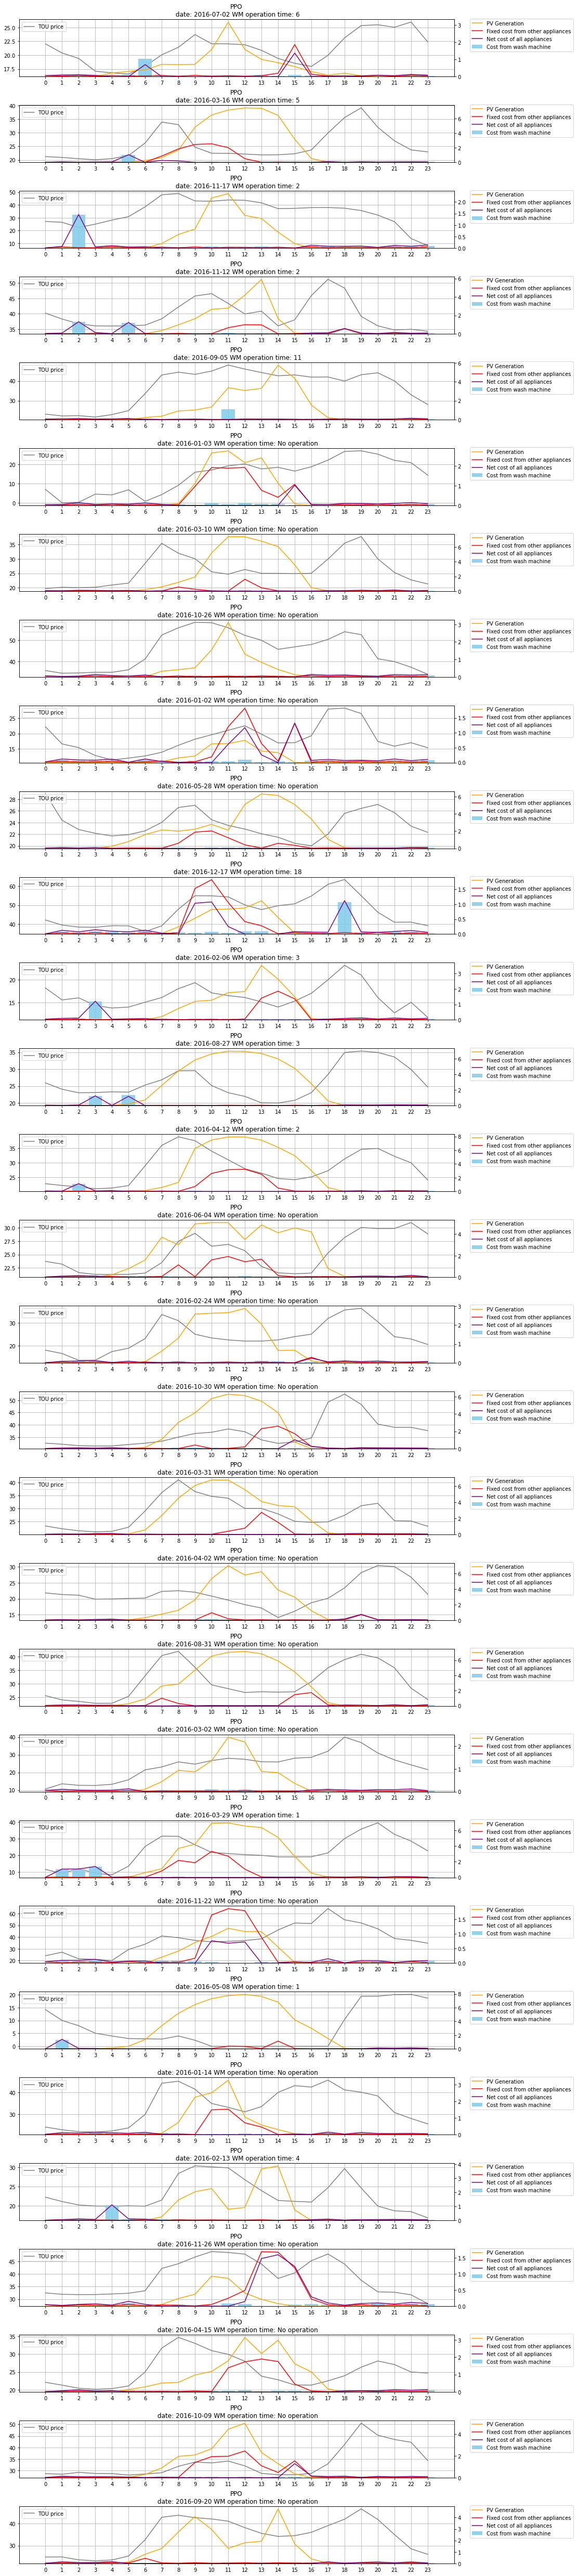

In [74]:
PPOTrial(df, 20000, 8, 22, 3, 1, 3, 3)
model = PPOLoad(20000, 8, 22, 3, 1, 3, 3)
generateGraph(model,20000, 8, 22, 3, 1, 3, 3)

for tS in timeSteps:
  for eL in energyLimits:
    for pT in penaltyTimes:
      for pE in penaltyEnergyLimits:
        for pO in penaltyOperationTimes:
          PPOTrial(df,tS, 8, 22, eL, pT, pE, pO)
      

# Hyperparameter Tuning

In [ ]:
# timeSteps = [i for i in range(1000, 30001, 30000)]
# energyLimits = [i for i in range(7, 9)]
# penaltyTimes = [i for i in range(9, 11)]
# penaltyEnergyLimits = [i for i in range(9, 11)]
# penaltyOperationTimes = [i for i in range(9, 11)]
for tS in timeSteps:
  for eL in energyLimits:
    for pT in penaltyTimes:
      for pE in penaltyEnergyLimits:
        for pO in penaltyOperationTimes:
          filePath = '/content/drive/MyDrive/Capstone/ppo/ppo_timeSteps'+str(tS)+'_sT'+str(8)+'_eT'+str(22)+'_eL'+str(eL)+'_pT'+str(pT)+'_pE'+str(pE)+'_pO'+str(pO)
          if os.path.exists(filePath +'.zip') == False:
            PPOTrial(df, tS, 8, 22, eL, pT, pE, pO)
         

  74% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 18,403/25,000  [ 0:02:02 < 0:00:44 , 153 it/s ]

<ipython-input-7-64dbb3c3599d>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(5,1,figsize = (15,15))
<ipython-input-7-64dbb3c3599d>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(5,1,figsize = (15,15))
<ipython-input-7-64dbb3c3599d>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

IndexError: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

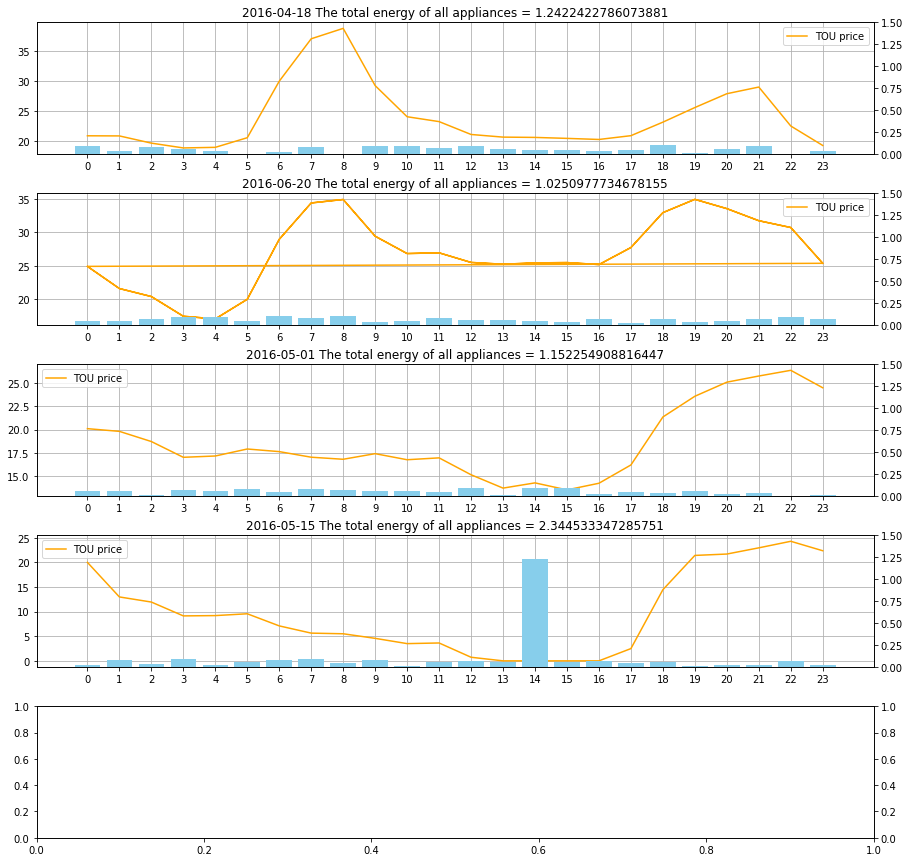

In [13]:
for tS in timeSteps:
  for eL in energyLimits:
    for pT in penaltyTimes:
      for pE in penaltyEnergyLimits:
        for pO in penaltyOperationTimes:
          filePath = '/content/drive/MyDrive/Capstone/ppo/ppo_timeSteps'+str(tS)+'_sT'+str(8)+'_eT'+str(22)+'_eL'+str(eL)+'_pT'+str(pT)+'_pE'+str(pE)+'_pO'+str(pO)
          if os.path.exists(filePath +'.png') == False:
            model = PPOLoad(tS, 8, 22, eL, pT, pE, pO)
            generateGraph(model, tS, 8, 22,  eL, pT, pE, pO)  

The model with the best performance has following hyperparameters:


In [91]:
print('Timesteps: ' + str(15000) + '\n' + 
      'EnergyMaxLimit: ' + str(3) + '\n' + 
      'penalty_time: ' + str(1) + '\n' + 
      'penaltyEnergyLimits: ' + str(3) + '\n' + 
      'penaltyOperationTimes: ' + str(3) + '\n'
      )

Timesteps: 15000
EnergyMaxLimit: 3
penalty_time: 1
penaltyEnergyLimits: 3
penaltyOperationTimes: 3



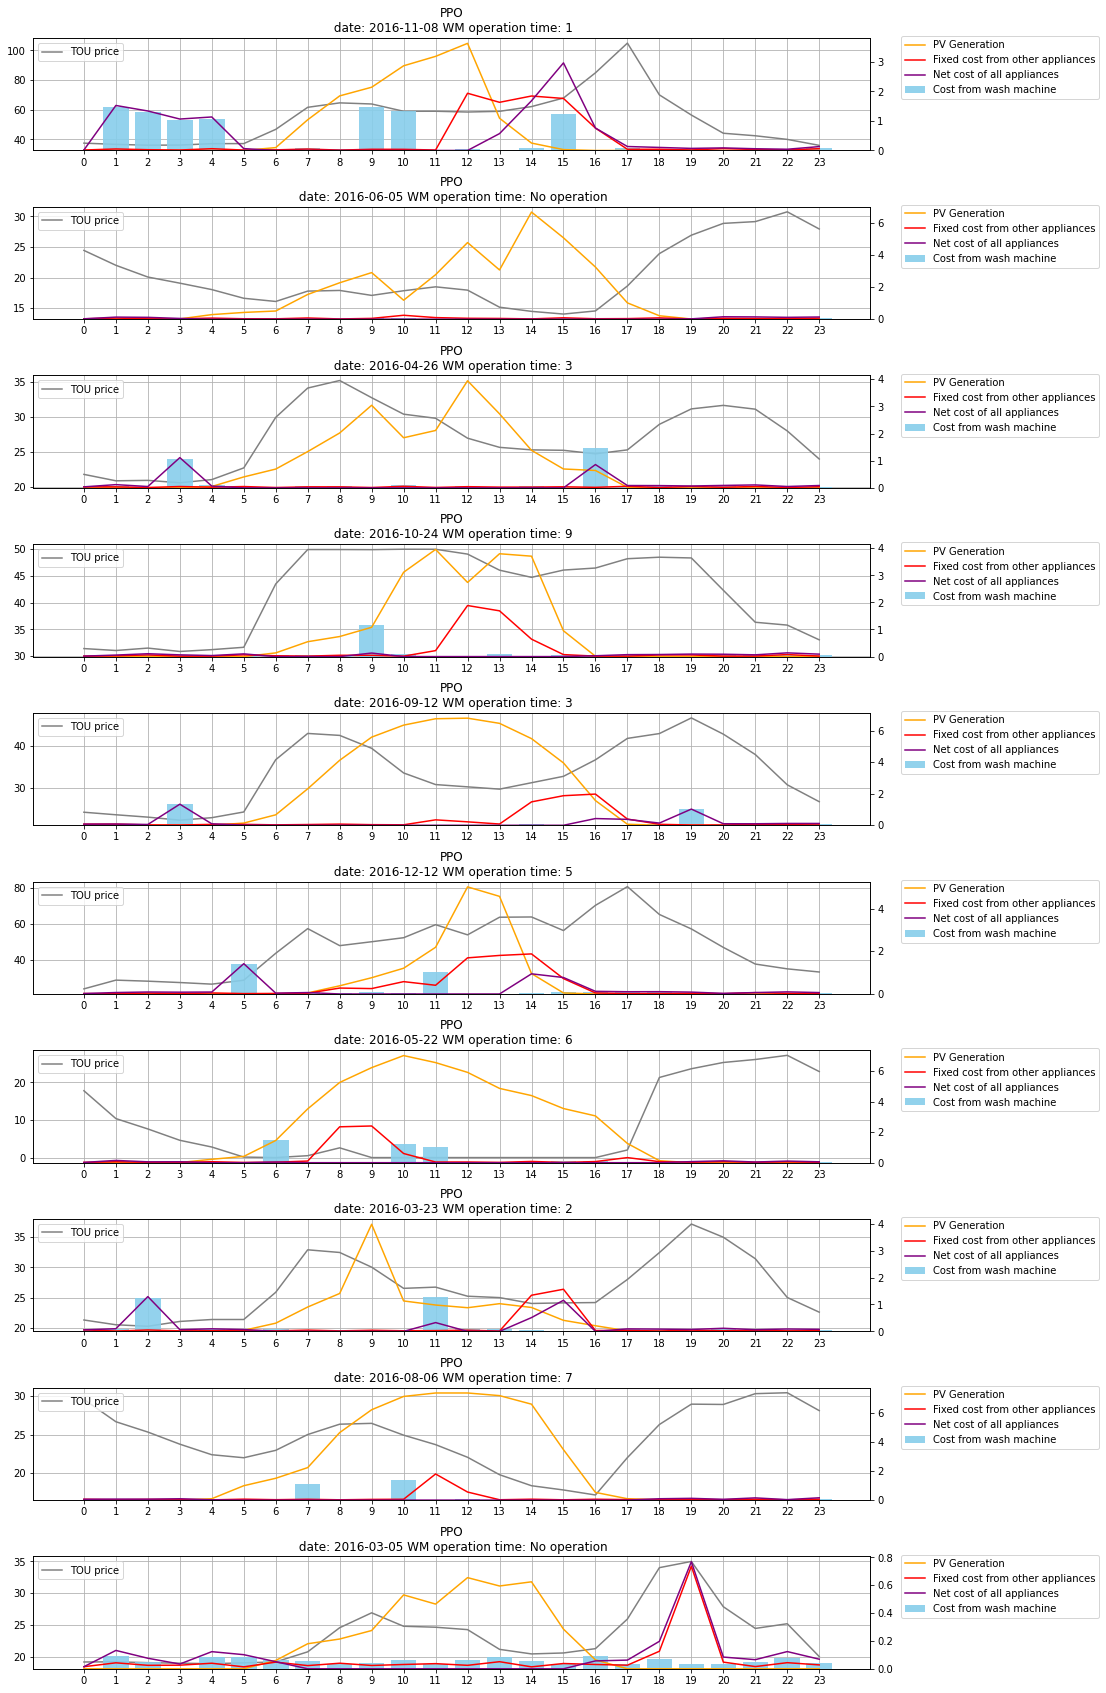

In [90]:
model = PPOLoad(15000, 8, 22, 3, 1, 3, 3)
generateGraph(model,15000, 8, 22, 3, 1, 3, 3)